In [1]:
function naive_multiplication(A,B)
    C=zeros(Float64,size(A,1),size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j]=C[i,j]+A[i,k]*B[k,j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

In [2]:
function better_multiplication( A,B )
    C=zeros(Float64,size(A,1),size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j]=C[i,j]+A[i,k]*B[k,j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

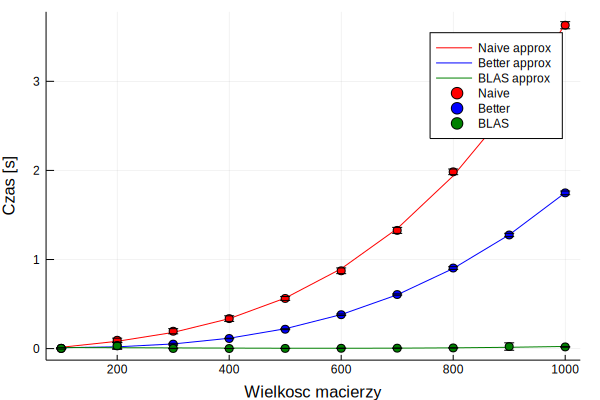

In [7]:
# import Pkg
# Pkg.add("Polynomials")
# Pkg.add("DataFrames")
# Pkg.add("Plots")
# Pkg.add("StatsBase")
using DataFrames
using Statistics
using Plots
using StatsBase
using Polynomials

i=100

df = DataFrame()
df.N = zeros(0)
df.Naive = []
df.Better = []
df.BLAS = []
df.MeanNaive = zeros(0)
df.MeanBetter = zeros(0)
df.MeanBLAS = zeros(0)
df.StdNaive = zeros(0)
df.StdBetter = zeros(0)
df.StdBLAS = zeros(0)


while i <= 1000
    results_naive = zeros(0)
    results_better = zeros(0)
    results_blas = zeros(0)
    A = rand(i,i)
    B = rand(i,i)
    
    for n = 1:10
        append!( results_naive, (@timed naive_multiplication(A,B))[2] )
        append!( results_better, (@timed better_multiplication(A,B))[2] )
        append!( results_blas, (@timed A*B)[2] )
    end
    df2 = DataFrame()
    df2.N = i
    df2.Naive = [results_naive]
    df2.Better = [results_better]
    df2.BLAS = [results_blas]
    df2.MeanNaive = mean(results_naive)
    df2.MeanBetter = mean(results_better)
    df2.MeanBLAS = mean(results_blas)
    df2.StdNaive = std(results_naive)
    df2.StdBetter = std(results_better)
    df2.StdBLAS = std(results_blas)
    append!(df, df2)
    
    i = i + 100
end

fit = [polyfit(df[:N], df[:MeanNaive], 3),
        polyfit(df[:N], df[:MeanBetter], 3),
        polyfit(df[:N], df[:MeanBLAS], 3)]
plot(df[:N], [polyval(fit[1], df[:N]), polyval(fit[2], df[:N]), polyval(fit[3], df[:N])], colour = [:red :blue :green], label=["Naive approx" "Better approx" "BLAS approx"])
scatter!(df[:N], [df[:MeanNaive], df[:MeanBetter], df[:MeanBLAS]], colour = [:red :blue :green], yerr=[df[:StdNaive] df[:StdBetter] df[:StdBLAS]], xlabel = "Wielkosc macierzy", ylabel = "Czas [s]", label=["Naive" "Better" "BLAS"])

In [4]:
#include <stdio.h>
#include <stdlib.h>
#include <gsl/gsl_blas.h>
#include <gsl/gsl_blas_types.h>
#include <gsl/gsl_vector.h>
#include <time.h>
#include <sys/time.h>
#include <sys/types.h>
#include <stdint.h>

uint64_t naive_multiplication(int n) {
    double ** A = (double **) malloc (n * sizeof(double *));
    double ** B = (double **) malloc (n * sizeof(double *));
    double ** C = (double **) malloc (n * sizeof(double *));
    for(int i = 0; i < n; i++) {
        A[i] = (double *) malloc (n * sizeof(double));
        B[i] = (double *) malloc (n * sizeof(double));
        C[i] = (double *) calloc (n, sizeof(double));
    }

    for(int i = 0; i < n; i++) {
        for(int j = 0; j < n; j++) {
            A[i][j] = i + j + 2;
            B[i][j] = i + j + 2;
        }
    }

    struct timespec start, end;
    uint64_t res;

    clock_gettime(0, &start);
    for(int j = 0; j < n; j++) {
        for(int k = 0; k < n; k++) {
            for(int i = 0; i < n; i++) {
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }
    clock_gettime(0, &end);
    res = (end.tv_sec - start.tv_sec) * 1000000 + (end.tv_nsec - start.tv_nsec) / 1000;
        
    for(int i = 0; i < n; i++) {
        free(A[i]);
        free(B[i]);
        free(C[i]);
    }
    free(A);
    free(B);
    free(C);
    return res;
}

uint64_t better_multiplication(int n) {
    double ** A = (double **) malloc (n * sizeof(double *));
    double ** B = (double **) malloc (n * sizeof(double *));
    double ** C = (double **) malloc (n * sizeof(double *));
    for(int i = 0; i < n; i++) {
        A[i] = (double *) malloc (n * sizeof(double));
        B[i] = (double *) malloc (n * sizeof(double));
        C[i] = (double *) calloc (n, sizeof(double));
    }

    for(int i = 0; i < n; i++) {
        for(int j = 0; j < n; j++) {
            A[i][j] = i + j + 2;
            B[i][j] = i + j + 2;
        }
    }

    struct timespec start, end;
    uint64_t res;

    clock_gettime(0, &start);
    for(int i = 0; i < n; i++) {
        for(int j = 0; j < n; j++) {
            for(int k = 0; k < n; k++) {
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }
    clock_gettime(0, &end);
    res = (end.tv_sec - start.tv_sec) * 1000000 + (end.tv_nsec - start.tv_nsec) / 1000;
        
    for(int i = 0; i < n; i++) {
        free(A[i]);
        free(B[i]);
        free(C[i]);
    }
    free(A);
    free(B);
    free(C);
    return res;
}

uint64_t dgemm(int n) {
    gsl_matrix * matrix1, * matrix2, * result;
    int i, j;
    struct timespec start, end;
    uint64_t res;
    matrix1 = gsl_matrix_alloc(n, n);
    matrix2 = gsl_matrix_alloc(n, n);
    result = gsl_matrix_alloc(n, n);
    for(i = 0; i < n; i++) {
        for(j = 0; j < n; j++) {
            gsl_matrix_set(matrix1, i, j, (double) i+j+2);
            gsl_matrix_set(matrix2, i, j, (double) i+j+2);
        }
    }
    clock_gettime(0, &start);
    gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, matrix1, matrix2, 0.0, result);
    clock_gettime(0, &end);
    res = (end.tv_sec - start.tv_sec) * 1000000 + (end.tv_nsec - start.tv_nsec) / 1000;
    gsl_matrix_free(result);
    gsl_matrix_free(matrix1);
    gsl_matrix_free(matrix2);
    return res;
}

int main() {
    uint64_t result;
    FILE * file;
    file = fopen("./csv.csv", "w+");
    fprintf(file, "N;Naive;Better;BLAS\n");

    better_multiplication(3);

    int n = 50;
    for(int j=0; j<=15; j++){
        fprintf(file, "%d;", n);
                                                                    
        for(int i=0; i<10; i++) {
            result = naive_multiplication(n);
            fprintf(file, "%jd ", result);
        }
        fprintf(file, ";", result);                                                                
                                                                        
        for(int i=0; i<10; i++) {
            result = better_multiplication(n);
            fprintf(file, "%jd ", result);
        }
        fprintf(file, ";", result);   
                                                                            
        for(int i=0; i<10; i++) {
            result = dgemm(n);
            fprintf(file, "%jd ", result);
        }
                                                                                
        fprintf(file, "\n", result);
        n += 10;
    }

   fclose(file);
    return 0;
}

LoadError: syntax: extra token "naive_multiplication" after end of expression

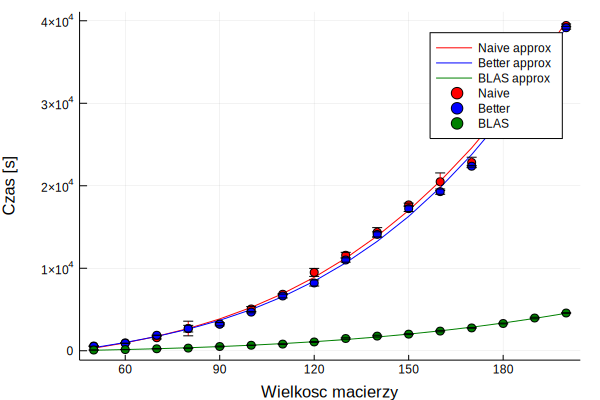

In [5]:
# import Pkg
# Pkg.add("DataFrames")
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("StatsBase")
using DataFrames
using CSV
using Plots
using Statistics
using StatsBase
df1 = DataFrame()
input = "csv3.csv"
df1 = CSV.read(input, delim = ";"; datarow=2 )
df1[:Naive] = [map(l -> parse(Int64, l), split(df1[x, :Naive])) for x in 1:size(df1, 1)]
df1[:Better] = [map(l -> parse(Int64, l), split(df1[x, :Better])) for x in 1:size(df1, 1)]
df1[:BLAS] = [map(l -> parse(Int64, l), split(df1[x, :BLAS])) for x in 1:size(df1, 1)]
df1[:MeanNaive] = [mean(df1[x, :Naive]) for x in 1:size(df1, 1)]
df1[:MeanBetter] = [mean(df1[x, :Better]) for x in 1:size(df1, 1)]
df1[:MeanBLAS] = [mean(df1[x, :BLAS]) for x in 1:size(df1, 1)]
df1[:StdNaive] = [std(df1[x, :Naive]) for x in 1:size(df1, 1)]
df1[:StdBetter] = [std(df1[x, :Better]) for x in 1:size(df1, 1)]
df1[:StdBLAS] = [std(df1[x, :BLAS]) for x in 1:size(df1, 1)]
fit1 = [polyfit(df1[:N], df1[:MeanNaive], 3),
        polyfit(df1[:N], df1[:MeanBetter], 3),
        polyfit(df1[:N], df1[:MeanBLAS], 3)]
plot(df1[:N], [polyval(fit1[1], df1[:N]), polyval(fit1[2], df1[:N]), polyval(fit1[3], df1[:N])], colour = [:red :blue :green], label=["Naive approx" "Better approx" "BLAS approx"])
scatter!(df1[:N], [df1[:MeanNaive], df1[:MeanBetter], df1[:MeanBLAS]], colour = [:red :blue :green], yerr=[df1[:StdNaive] df1[:StdBetter] df1[:StdBLAS]], xlabel = "Wielkosc macierzy", ylabel = "Czas [s]", label=["Naive" "Better" "BLAS"])